# core

> A step-by-step explanation of TCP and implementation using Python's socket module

In [ ]:
#| default_exp core

## Introduction to TCP

The Transmission Control Protocol (TCP) is one of the main protocols of the Internet protocol suite. It provides reliable, ordered, and error-checked delivery of a stream of bytes between applications running on hosts communicating via an IP network.

TCP is:
- **Connection-oriented**: A connection is established before data is sent
- **Reliable**: It guarantees delivery of data to the destination
- **Ordered**: If packets arrive in the wrong order, TCP reorders them
- **Error-checked**: Corrupted packets are retransmitted

## The Three-Way Handshake

TCP establishes a connection through a process called the three-way handshake:

1. **SYN**: Client sends a SYN (synchronize) packet with a random sequence number `x`
2. **SYN-ACK**: Server responds with a SYN-ACK packet with its own sequence number `y` and acknowledgment number `x+1`
3. **ACK**: Client sends an ACK packet with acknowledgment number `y+1` to establish the connection

In [ ]:
#| hide_input
from IPython.display import SVG
from IPython.display import display

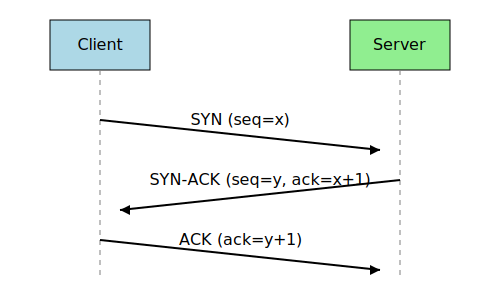

In [ ]:
svg_data = '''
<svg width="500" height="300" xmlns="http://www.w3.org/2000/svg">
    <rect width="100%" height="100%" fill="white"/>
    
    <!-- Entities -->
    <rect x="50" y="20" width="100" height="50" fill="lightblue" stroke="black"/>
    <text x="100" y="50" text-anchor="middle">Client</text>
    <rect x="350" y="20" width="100" height="50" fill="lightgreen" stroke="black"/>
    <text x="400" y="50" text-anchor="middle">Server</text>
    
    <!-- Lines -->
    <line x1="100" y1="70" x2="100" y2="280" stroke="gray" stroke-dasharray="5,5"/>
    <line x1="400" y1="70" x2="400" y2="280" stroke="gray" stroke-dasharray="5,5"/>
    
    <!-- Arrows -->
    <line x1="100" y1="120" x2="380" y2="150" stroke="black" stroke-width="2"/>
    <polygon points="380,150 370,145 370,155" fill="black"/>
    <text x="240" y="125" text-anchor="middle">SYN (seq=x)</text>
    
    <line x1="400" y1="180" x2="120" y2="210" stroke="black" stroke-width="2"/>
    <polygon points="120,210 130,205 130,215" fill="black"/>
    <text x="260" y="185" text-anchor="middle">SYN-ACK (seq=y, ack=x+1)</text>
    
    <line x1="100" y1="240" x2="380" y2="270" stroke="black" stroke-width="2"/>
    <polygon points="380,270 370,265 370,275" fill="black"/>
    <text x="240" y="245" text-anchor="middle">ACK (ack=y+1)</text>
</svg>
'''

display(SVG(data=svg_data))

## Socket API in Python

Python's `socket` module provides a simple API for creating TCP connections. Here are the key elements we'll use:

In [ ]:
#| export
import socket
from dataclasses import dataclass
from typing import Optional, List, Tuple, Dict, Any, Union
import threading
import time

We will create a simplified wrapper around Python's socket API to make it easier to understand TCP concepts.

In [ ]:
#| export
def get_free_port() -> int:
    """Get an available port number by creating and closing a temporary socket."""
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(('', 0))
        return s.getsockname()[1]

Let's define some constants for our implementation:

In [ ]:
#| export
LOCALHOST = '127.0.0.1'
DEFAULT_BUFFER_SIZE = 1024
DEFAULT_BACKLOG = 5  # Maximum number of queued connections

## Socket State Information

TCP sockets go through various states during their lifecycle:

- **CLOSED**: No connection
- **LISTEN**: Server is waiting for incoming connections
- **SYN_SENT**: Client has sent SYN packet
- **SYN_RECEIVED**: Server has received SYN and sent SYN-ACK
- **ESTABLISHED**: Connection is established
- **FIN_WAIT**: Connection termination in progress
- **CLOSE_WAIT**: Waiting for application to close
- **CLOSING**: Both sides have initiated connection termination
- **TIME_WAIT**: Waiting to ensure remote TCP received connection termination
- **LAST_ACK**: Waiting for last acknowledgement

We'll create utility functions to help us track these states in our implementation.

In [ ]:
#| export
# Socket states
class SocketState:
    """Constants for socket states."""
    CLOSED = "CLOSED"
    LISTEN = "LISTEN"
    SYN_SENT = "SYN_SENT"
    SYN_RECEIVED = "SYN_RECEIVED"
    ESTABLISHED = "ESTABLISHED"
    FIN_WAIT_1 = "FIN_WAIT_1"
    FIN_WAIT_2 = "FIN_WAIT_2"
    CLOSE_WAIT = "CLOSE_WAIT"
    CLOSING = "CLOSING"
    LAST_ACK = "LAST_ACK"
    TIME_WAIT = "TIME_WAIT"

Now let's define a basic connection structure that will help us manage TCP connections:

In [ ]:
#| export
@dataclass
class TCPConnection:
    """Represents a TCP connection with state information."""
    socket: Optional[object] = None
    state: str = SocketState.CLOSED
    remote_address: Optional[Tuple[str, int]] = None
    connection_id: Optional[str] = None
    
    def __str__(self) -> str:
        addr = f"{self.remote_address[0]}:{self.remote_address[1]}" if self.remote_address else "None"
        return f"Connection[{self.connection_id or 'unknown'}] to {addr} (state: {self.state})"
    
    def update_state(self, new_state: str) -> None:
        """Update connection state with logging."""
        prev_state = self.state
        self.state = new_state
        # Normally we'd log this state transition
        print(f"Connection {self.connection_id}: {prev_state} -> {self.state}")

## TCP Connection Lifecycle

A TCP connection goes through the following phases:
1. Connection establishment (three-way handshake)
2. Data transfer
3. Connection termination (four-way handshake)

In our implementation, we'll focus on making these phases explicit and easy to understand.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()